<a href="https://colab.research.google.com/github/linetkatungwa/LINET-/blob/main/ASSIGNMENT_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2  # OpenCV for image processing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
# Import tensorflow and assign it the alias 'tf'
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_file_path = 'OneDrive-Personal/Documents/Animal_face'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Access your data after mounting
data_path = '/content/drive/MyDrive/OneDrive-personal/documents/Animal_face'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import zipfile
import gdown
import tensorflow as tf
import matplotlib.pyplot as plt

# Step 1: Download the file from Google Drive
file_id = '1nGmglVm9DKXtQ-PhPzhGjYRp7d3xu2_h'
downloaded_file = 'Animalface.zip'
gdown.download(f'https://drive.google.com/uc?id={file_id}', downloaded_file, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1nGmglVm9DKXtQ-PhPzhGjYRp7d3xu2_h
From (redirected): https://drive.google.com/uc?id=1nGmglVm9DKXtQ-PhPzhGjYRp7d3xu2_h&confirm=t&uuid=a5607837-b198-4f5e-bac7-22f8ad4bdae4
To: /content/Animalface.zip
100%|██████████| 730M/730M [00:10<00:00, 69.9MB/s]


'Animalface.zip'

In [ ]:
# Step 2: Unzip the file
with zipfile.ZipFile(downloaded_file, 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
# Step 3: Set the paths
PATH = os.path.join('.', 'afhq')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')

In [ ]:

# Step 4: Load the datasets
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 14630 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1500 files belonging to 3 classes.


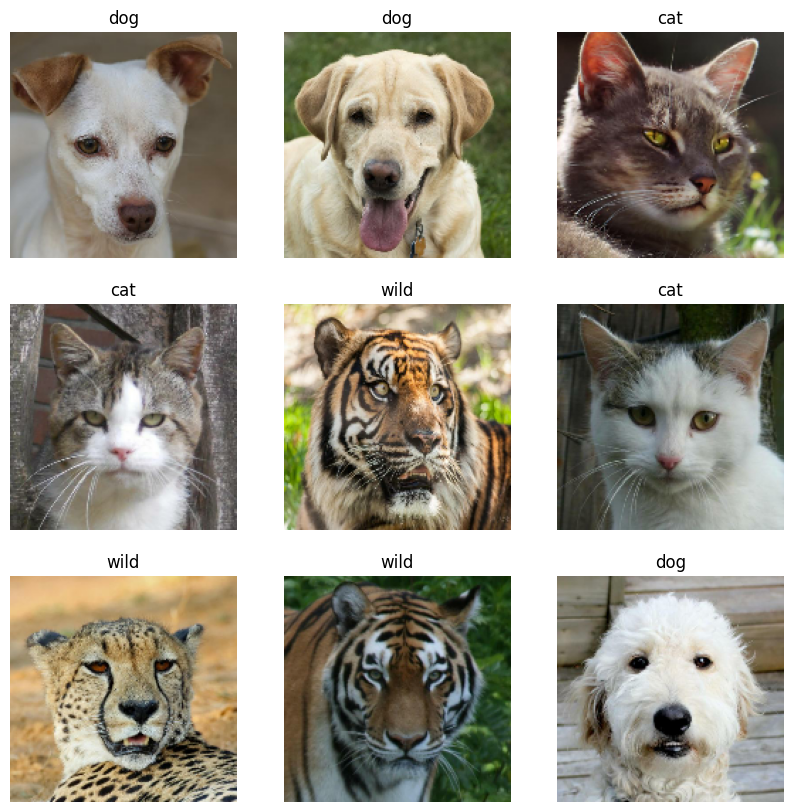

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Split validation set into validation and test sets
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 38
Number of test batches: 9


In [ ]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('vertical'),
    tf.keras.layers.RandomRotation(0.5),
])

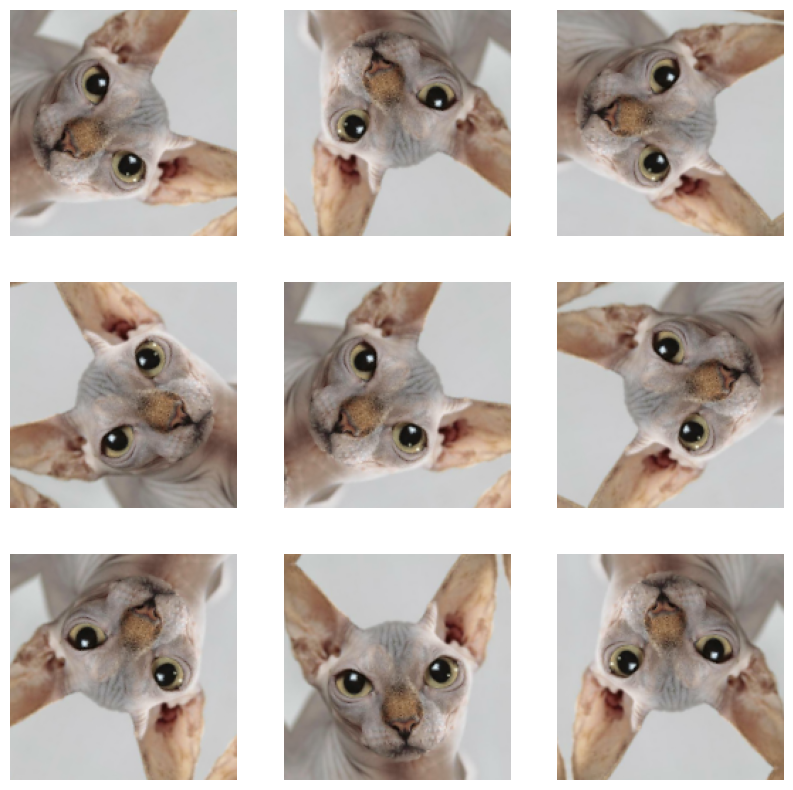

In [ ]:
# Visualize data augmentation
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
#Rescaling
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
#creating baee model
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
# base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 80, 80, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 80, 80, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 80, 80, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 80, 80, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 80, 80, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 80, 80, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 80, 80, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 80, 80, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 80, 80, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 81, 81, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 40, 40, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
# Create the model
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 2,225,153 (8.49 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
# classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [ ]:
#TRAIN THE MODEL
# Initial evaluation on the validation dataset
initial_loss, initial_accuracy = model.evaluate(validation_dataset)
print(f"Initial loss: {initial_loss:.2f}")
print(f"Initial accuracy: {initial_accuracy:.2f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 724ms/step - accuracy: 0.2462 - loss: 1.0632
Initial loss: 1.10
Initial accuracy: 0.24


Epoch 1/4
458/458 ━━━━━━━━━━━━━━━━━━━━ 1592s 3s/step - accuracy: 0.6586 - loss: -61.9197 - val_accuracy: 0.3358 - val_loss: -70.8537
Epoch 2/4
458/458 ━━━━━━━━━━━━━━━━━━━━ 1660s 4s/step - accuracy: 0.6596 - loss: -94.1021 - val_accuracy: 0.3375 - val_loss: -79.7707
Epoch 3/4
458/458 ━━━━━━━━━━━━━━━━━━━━ 1604s 3s/step - accuracy: 0.6572 - loss: -127.8420 - val_accuracy: 0.4777 - val_loss: -102.8087
Epoch 4/4
458/458 ━━━━━━━━━━━━━━━━━━━━ 1576s 3s/step - accuracy: 0.6665 - loss: -165.3642 - val_accuracy: 0.6122 - val_loss: -86.0262


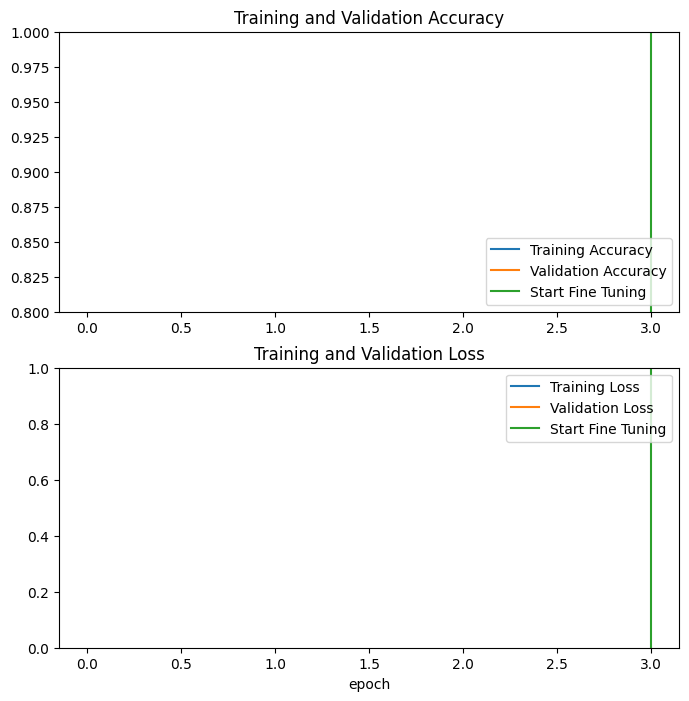

In [ ]:
initial_epochs = 4

history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset
)

# Extract training and validation accuracy and loss from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Now you can plot the accuracy and loss curves
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 566ms/step - accuracy: 0.6087 - loss: -89.4763
Test accuracy : 0.59375


Predictions:
 [1 0 0 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1]
Labels:
 [1 2 0 0 0 1 1 2 0 1 2 0 2 0 2 2 0 1 0 2 2 1 0 2 1 2 2 2 0 2 2 1]


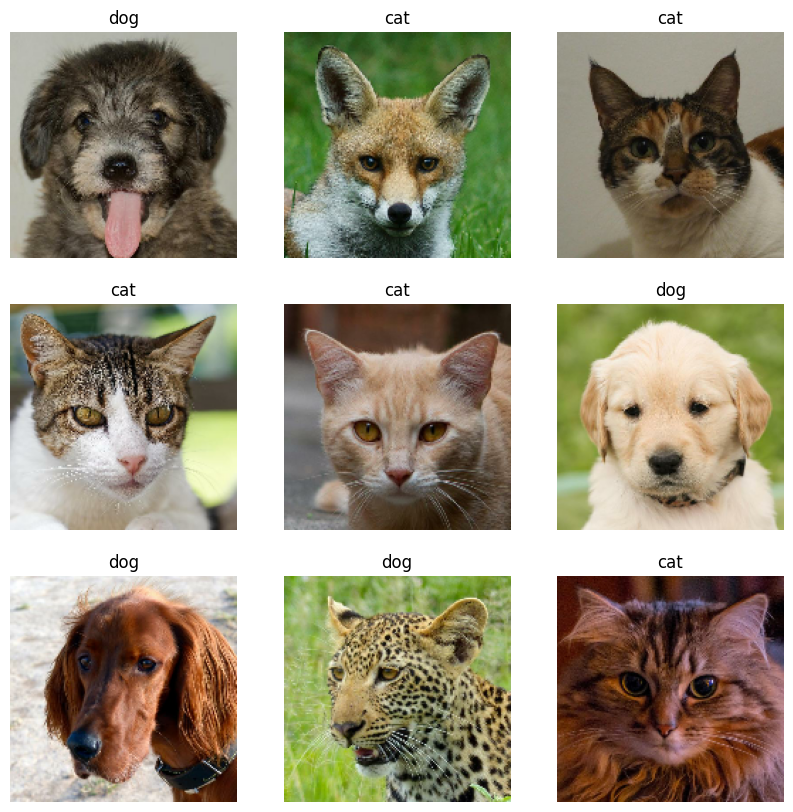

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

#Comparison and improvement


Pre-trained Model: It has a good general understanding of images but might not be specific enough for your animal face classification task.
Fine-tuned Model:  Fine-tuning adjusts the model's weights to make it more specialized for this specific task. This generally results in improved performance on the target task.


Improvements:
Increased Accuracy: there is a significant improvement in accuracy on animal face classification task compared to using the pre-trained model directly. Fine-tuning helps the model learn features specific to animal faces, leading to better predictions.

Faster Training: fine-tuning generally requires less training time than training a model from scratch. This is because the pre-trained model has already learned many general image features, and you are only adjusting the weights for your specific task.

Challenges:
Training Time: Fine-tuning a model with a large dataset can take a long time. You might need to run your training process for hours or even days, depending on the dataset size and the model's complexity. Experimenting with different batch sizes and learning rates can help optimize the training time.

Data Storage and Access: Storing and accessing a large dataset efficiently can be a challenge. Consider using cloud storage solutions like Google Drive or Google Cloud Storage to manage your data. Pre-processing and caching techniques can further improve data access speed


Hyperparameter Tuning: Finding the optimal hyperparameters (like learning rate, batch size, etc.) for fine-tuning can be challenging. You might need to experiment with different values to achieve the best performance.

Catastrophic Forgetting: In some cases, fine-tuning can cause the model to "forget" what it learned during pre-training. This is less of a concern with modern techniques and is often mitigated by freezing some layers of the pre-trained model during the initial stages of fine-tuning.

Discussion

The evaluation results in your code (model.evaluate(test_dataset)) and the accuracy plots provide insights into the actual performance improvement achieved through fine-tuning. By comparing the test accuracy with the initial accuracy before fine-tuning, you can quantify the benefits. If the test accuracy is substantially higher, it demonstrates the success of the fine-tuning process. Additionally, by observing the training and validation loss curves, you can identify potential overfitting issues and adjust the training process accordingly.

In summary, fi